# "Working with fastai - Low-Level API"
> "This notebook contains some experiments made with fastai's low level api with the MNIST dataset"

- toc: true
- branch: master
- badges: true
- author: João Marcelo Tozato
- image: images/low_level_api.png
- categories: [fastai, api]

### Imports

These are the imports for everything we'll be using in this notebook

In [ ]:
from torch import nn

from fastai.vision.all import *
from fastai.callback.hook import summary
from fastai.callback.schedule import fit_one_cycle, lr_find 
from fastai.callback.progress import ProgressCallback

from fastai.data.core import Datasets, DataLoaders, show_at
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import Categorize, GrandparentSplitter, parent_label, ToTensor, IntToFloatTensor, Normalize

from fastai.layers import Flatten
from fastai.learner import Learner

from fastai.metrics import accuracy, CrossEntropyLossFlat

from fastai.vision.augment import CropPad, RandomCrop, PadMode
from fastai.vision.core import PILImageBW
from fastai.vision.utils import get_image_files

In [15]:
#hide_input
from wwf.utils import state_versions
state_versions(['fastai', 'fastcore', 'wwf'])


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `fastai`, `fastcore`, and `wwf` currently running at the time of writing this:
* `fastai` : 2.2.5 
* `fastcore` : 1.3.12 
* `wwf` : 0.0.16 
---

grabbing our data

In [2]:
path = untar_data(URLs.MNIST)

### Working with the data

In [3]:
items = get_image_files(path)

In [4]:
items[0]

Path('/home/jmtzt/.fastai/data/mnist_png/testing/9/2934.png')

<AxesSubplot:>

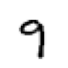

In [6]:
im = PILImageBW.create(items[0]); im.show()

Split our data with `GrandparentSplitter`, which will make use of a `train` and `valid` folder.

In [7]:
splits = GrandparentSplitter(train_name='training', valid_name='testing')

In [8]:
splits = splits(items)

In [9]:
splits[0][:5], splits[1][:5]

([10000, 10001, 10002, 10003, 10004], [0, 1, 2, 3, 4])

* Make a `Datasets`

* Expects items, transforms for describing our problem, and a splitting method

In [18]:
dsrc = Datasets(items, tfms=[[PILImageBW.create], [parent_label, Categorize]],
                  splits = splits)

<AxesSubplot:title={'center':'9'}>

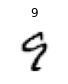

In [19]:
show_at(dsrc.train, 3)

Next we need to give ourselves some transforms on the data! These will need to:
1. Ensure our images are all the same size
2. Make sure our output are the `tensor` our models are wanting
3. Give some image augmentation

In [20]:
tfms = [ToTensor(), CropPad(size=34, pad_mode=PadMode.Zeros), RandomCrop(size=28)]

* `ToTensor`: Converts to tensor
* `CropPad` and `RandomCrop`: Resizing transforms
* Applied on the `CPU` via `after_item`

In [21]:
gpu_tfms = [IntToFloatTensor(), Normalize()]

* `IntToFloatTensor`: Converts to a float
* `Normalize`: Normalizes data

In [22]:
dls = dsrc.dataloaders(bs=128, after_item=tfms, after_batch=gpu_tfms)

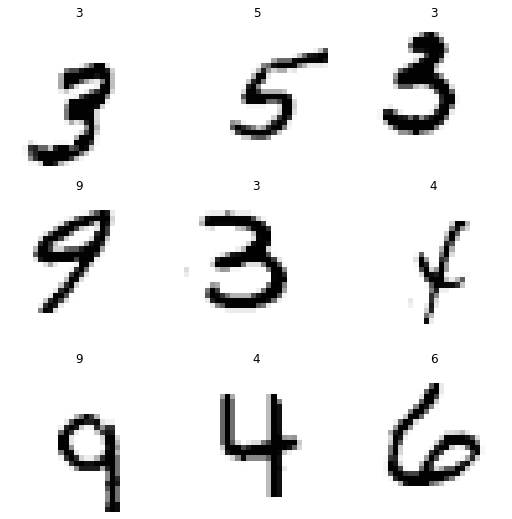

In [23]:
dls.show_batch()

In [24]:
xb, yb = dls.one_batch()

In [25]:
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [26]:
dls.c

10

So our input shape will be a [128 x 1 x 28 x 28] and our output shape will be a [128] tensor that we need to condense into 10 classes

### Model definition

* This model will have 5 convolutional layers
* We'll use `nn.Sequential`
* 1 -> 32 -> 10

In [28]:
def conv(ni, nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

Here we can see our `ni` is equivalent to the depth of the filter, and `nf` is equivalent to how many filters we will be using. (Fun fact this always has to be divisible by the size of our image).

#### Batch Normalization

As we send our tensors through our model, it is important to normalize our data throughout the network. Doing so can allow for a much larger improvement in training speed, along with allowing each layer to learn independantly (as each layer is then re-normalized according to it's outputs)

In [30]:
def bn(nf): return nn.BatchNorm2d(nf)

`nf` will be the same as the filter output from our previous convolutional layer

#### Activation functions

They give our models non-linearity and work with the `weights` we mentioned earlier along with a `bias` through a process called **back-propagation**. These allow our models to learn and perform more complex tasks because they can choose to fire or activate one of those neurons mentioned earlier. On a simple sense, let's look at the `ReLU` activation function. It operates by turning any negative values to zero, as visualized below:

![](https://miro.medium.com/max/2052/1*DfMRHwxY1gyyDmrIAd-gjQ.png)

In [31]:
def ReLU(): return nn.ReLU(inplace=False)

In [32]:
model = nn.Sequential(
    conv(1, 8),
    bn(8),
    ReLU(),
    conv(8, 16),
    bn(16),
    ReLU(),
    conv(16,32),
    bn(32),
    ReLU(),
    conv(32, 16),
    bn(16),
    ReLU(),
    conv(16, 10),
    bn(10),
    Flatten()
)

In [33]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [34]:
learn.summary()

Sequential (Input shape: 128)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 8 x 14 x 14   
Conv2d                                    80         True      
BatchNorm2d                               16         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 16 x 7 x 7    
Conv2d                                    1168       True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 32 x 4 x 4    
Conv2d                                    4640       True      
BatchNorm2d                               64         True      
ReLU                                                           
__________________________________________________

`learn.summary` also tells us:
* Total parameters
* Trainable parameters
* Optimizer
* Loss function
* Applied `Callbacks`

SuggestedLRs(lr_min=0.2290867567062378, lr_steep=0.5248074531555176)

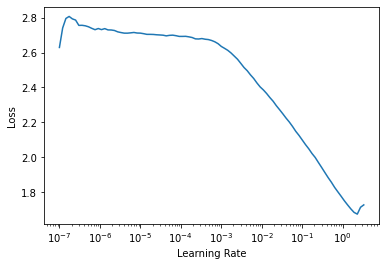

In [35]:
learn.lr_find()

In [36]:
learn.fit_one_cycle(3, lr_max=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.210623,0.194198,0.939300,00:09
1,0.139447,0.079532,0.975500,00:09
2,0.068283,0.037102,0.987500,00:09


### Simplifying our model

* Try to make it more like `ResNet`.
* `ConvLayer` contains a `Conv2d`, `BatchNorm2d`, and an activation function

In [37]:
def conv2(ni, nf): return ConvLayer(ni, nf, stride=2)

In [38]:
net = nn.Sequential(
    conv2(1,8),
    conv2(8,16),
    conv2(16,32),
    conv2(32,16),
    conv2(16,10),
    Flatten()
)

In [39]:
learn = Learner(dls, net, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [40]:
learn.fit_one_cycle(3, lr_max=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.202230,0.219875,0.931000,00:09
1,0.130472,0.079829,0.972500,00:09
2,0.076784,0.038371,0.986900,00:09


### ResNet (kind of)

The ResNet architecture is built with what are known as ResBlocks. Each of these blocks consist of two `ConvLayers` that we made before, where the number of filters do not change. Let's generate these layers. 

In [41]:
class ResBlock(Module):
    
    def __init__(self, nf):
        self.conv1 = ConvLayer(nf, nf)
        self.conv2 = ConvLayer(nf, nf)

        
    def forward(self, x): return x + self.conv2(self.conv1(x))

* Class notation
* `__init__`
* `forward`

In [42]:
net = nn.Sequential(
    conv2(1,8),
    ResBlock(8),
    conv2(8,16),
    ResBlock(16),
    conv2(16,32),
    ResBlock(32),
    conv2(32,16),
    ResBlock(16),
    conv2(16,10),
    Flatten()
)

Awesome! We're building a pretty substantial model here. Let's try to make it **even simpler**. We know we call a convolutional layer before each `ResBlock` and they all have the same filters, so let's make that layer!

In [44]:
def conv_and_res(ni, nf): return nn.Sequential(conv2(ni, nf), ResBlock(nf))

In [46]:
net = nn.Sequential(
    conv_and_res(1,8),
    conv_and_res(8,16),
    conv_and_res(16,32),
    conv_and_res(32,16),
    conv2(16,10),
    Flatten()
)

And now we have something that resembles a ResNet! Let's see how it performs

In [47]:
learn = Learner(dls, net, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.3630780577659607)

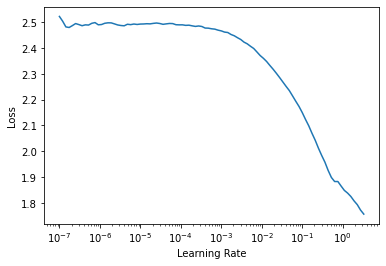

In [48]:
learn.lr_find()

In [49]:
learn.fit_one_cycle(3, lr_max=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.154220,0.295265,0.907000,00:10
1,0.087304,0.072216,0.976400,00:10
2,0.041664,0.023510,0.992200,00:10


In [50]:
learn.path = Path('')
learn.export(fname='export.pkl')